In [1]:
import sys
sys.path.append("./src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

from Features import FeatureEngineer
from Environment import TradingEnvironment , random_policy

from tqdm import tqdm


In [2]:
gaz = pd.read_csv('data/Dutch TTF Natural Gas Futures - Données Historiques (1).csv')
fe_gaz = FeatureEngineer(gaz)
fe_gaz.apply_preprocessing()
gaz_df = fe_gaz.df

data = gaz_df["Dernier"]
len(data)

c:\Users\alexa\Documents\Visual Studio Code\Reinforcement-Learning-Project\./src\Features.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.df['Date']=pd.to_datetime(self.df['Date'])


1568

# Environment

In [3]:
env = TradingEnvironment(data)

# env.observation_space.shape[0]
# env.action_space.n

# env.index_loc
# env.index_step
# env.index_loc + env.index_step

In [4]:
backtest_history = env.run_backtest(random_policy)

history_df = pd.DataFrame(backtest_history)
history_df

,balance,price,position,action,new_balance,new_price,new_position,reward,done
0,10000.000,17.970,0,0,10000.000,17.760,0,10000.000,False
1,10000.000,17.760,0,0,10000.000,17.265,0,10000.000,False
2,10000.000,17.265,0,0,10000.000,18.045,0,10000.000,False
3,10000.000,18.045,0,0,10000.000,18.390,0,10000.000,False
4,10000.000,18.390,0,0,10000.000,18.590,0,10000.000,False
...,...,...,...,...,...,...,...,...,...
355,9002.383,192.185,17,-1,9194.568,205.365,16,12480.408,False
356,9194.568,205.365,16,-1,9399.933,208.110,15,12521.583,False
357,9399.933,208.110,15,-1,9608.043,206.110,14,12493.583,False
358,9608.043,206.110,14,1,9401.933,220.110,15,12703.583,False


In [ ]:
def visualize(prices, actions):
    buy_signals = []
    sell_signals = []

    for i in range(len(price)):
        if action[i] == 1:
            buy_signals.append(price[i])
            sell_signals.append(None)
        elif action[i] == -1:
            buy_signals.append(None)
            sell_signals.append(price[i])
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    plt.figure(figsize=(10, 6))
    plt.plot(price, color='blue', label='Price')
    plt.scatter(range(len(price)), buy_signals, color='green', label='Buy Signal', zorder=5)
    plt.scatter(range(len(price)), sell_signals, color='red', label='Sell Signal', zorder=5)
    plt.title('Price with Buy/Sell Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

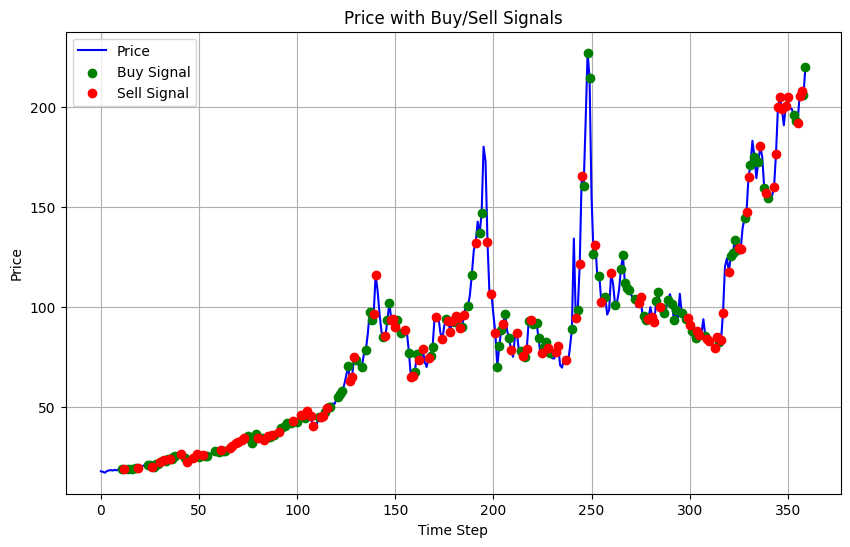

In [5]:
price = history_df['price']
action = history_df['action']

buy_signals = []
sell_signals = []

for i in range(len(price)):
    if action[i] == 1:
        buy_signals.append(price[i])
        sell_signals.append(None)
    elif action[i] == -1:
        buy_signals.append(None)
        sell_signals.append(price[i])
    else:
        buy_signals.append(None)
        sell_signals.append(None)

plt.figure(figsize=(10, 6))
plt.plot(price, color='blue', label='Price')
plt.scatter(range(len(price)), buy_signals, color='green', label='Buy Signal', zorder=5)
plt.scatter(range(len(price)), sell_signals, color='red', label='Sell Signal', zorder=5)
plt.title('Price with Buy/Sell Signals')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# ReplayMemory

In [6]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.memory)
    

# DQN

In [7]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.softmax(self.fc3(x))
        x = self.fc3(x)
        return x

# Params

In [8]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LR = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciation

In [9]:
num_observations = env.observation_space.shape[0]
num_actions = env.action_space.n

state = env.reset()

policy_net = DQN(num_observations, num_actions).to(device)
target_net = DQN(num_observations, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
replay_memory = ReplayMemory(10000)

# Greedy action

In [10]:
def epsilon_greedy_action(state, index_step):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * index_step / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
            # torch.Size([1, 1])
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        # torch.Size([1, 1])

# Train

In [11]:
def train_dqn(num_episodes):

    policy_net.train()
    history = []

    for episode in tqdm(range(num_episodes)):

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(0)
        # torch.Size([1, 3])

        for t in range(env.max_steps):

            action = epsilon_greedy_action(state, t) # torch.Size([1, 1])
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) # torch.Size([1, 3])
            reward = torch.tensor([reward], device=device)

            replay_memory.push(state, action, reward, next_state, done)

            state = next_state

            if len(replay_memory) > BATCH_SIZE:

                states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)

                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                states = states.squeeze(1) 
                # torch.Size([batch_size, num_actions])
                next_states = states.squeeze(1)
                # torch.Size([batch_size, num_actions])
                actions = actions.unsqueeze(1)
                # torch.Size([batch_size, 1])

                state_action_values = policy_net(states).gather(1, actions)
                # torch.Size([batch_size, 1])
                next_state_values = target_net(next_states).max(1)[0].detach()
                # torch.Size([batch_size, num_actions])
                expected_state_action_values = rewards + (1 - dones) * GAMMA * next_state_values

                criterion = nn.SmoothL1Loss()
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break
        
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        
        history.append(env.info)

        # print(f"Episode: {episode+1}, End Reward: {balance + price*pos}")

    return history
    
# Train the DQN
history = train_dqn(num_episodes=100)

100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


In [12]:
df = pd.DataFrame(history)
df

,balance,price,position,action,new_balance,new_price,new_position,reward,done
0,7418.510,193.055,20,0,7418.510,192.185,20,11262.210,True
1,9302.430,3.510,50,0,9302.430,4.385,50,9521.680,True
2,8770.289,25.100,16,0,8770.289,27.070,16,9203.409,True
3,9699.600,13.755,34,0,9699.600,13.840,34,10170.160,True
4,9740.015,15.540,21,0,9740.015,15.960,21,10075.175,True
...,...,...,...,...,...,...,...,...,...
95,9937.000,13.285,2,1,9923.715,13.180,3,9963.255,True
96,9954.285,6.995,0,0,9954.285,6.620,0,9954.285,True
97,30.148,198.610,113,-1,228.758,217.880,112,24631.318,True
98,50.903,79.405,118,0,50.903,84.880,118,10066.743,True


In [13]:
df.reward.mean()

9843.057630000001

# Eval 

In [65]:
def eval_dqn(num_episodes):

    policy_net.eval()
    history = dict()

    for episode in tqdm(range(num_episodes)):

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(0)

        episode_history = []

        for _ in range(env.max_steps):

            action = policy_net(state).max(1).indices.view(1, 1)
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) # torch.Size([1, 3])
            reward = torch.tensor([reward], device=device)

            state = next_state

            episode_history.append(env.info)

            if done:
                break            
                
        history[episode+1] = episode_history

    return history
    
# Train the DQN
history = eval_dqn(num_episodes=1000)

100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


In [66]:
np.mean([v[-1]["reward"] for v in history.values()])    

15150.723082999999

In [71]:
df = pd.DataFrame(history[1])
df

,balance,price,position,action,new_balance,new_price,new_position,reward,done
0,10000.000,22.260,0,1,9977.740,22.465,1,10000.205,False
1,9977.740,22.465,1,1,9955.275,22.355,2,9999.985,False
2,9955.275,22.355,2,1,9932.920,22.730,3,10001.110,False
3,9932.920,22.730,3,1,9910.190,22.730,4,10001.110,False
4,9910.190,22.730,4,1,9887.460,22.580,5,10000.360,False
...,...,...,...,...,...,...,...,...,...
355,3527.550,15.980,355,1,3511.570,16.330,356,9325.050,False
356,3511.570,16.330,356,1,3495.240,15.810,357,9139.410,False
357,3495.240,15.810,357,1,3479.430,15.770,358,9125.090,False
358,3479.430,15.770,358,1,3463.660,15.880,359,9164.580,False


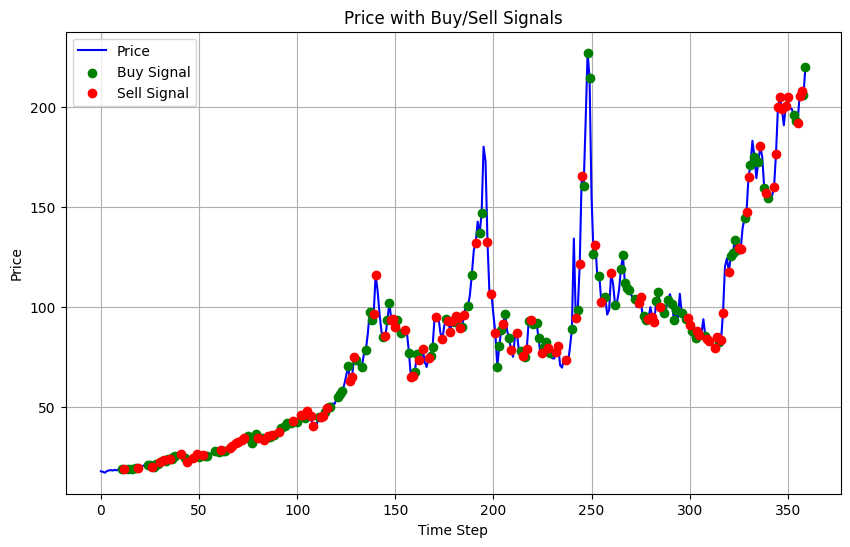

In [68]:
visualize(df.price, df.action)

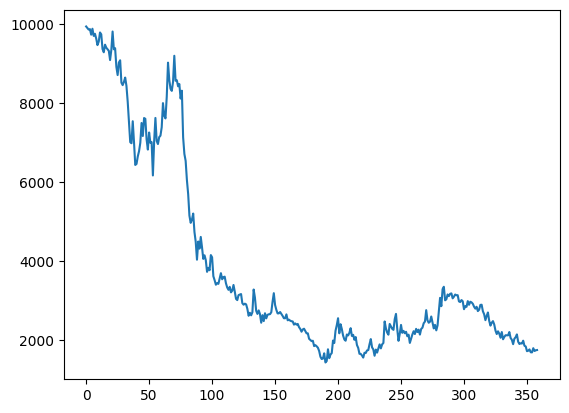

In [69]:
plt.plot(df.reward)

In [22]:
history_1_df = pd.DataFrame(history[0])
history_1_df

,balance,price,position,action,new_balance,new_price,new_position,reward,done
0,10000.000,17.760,0,1,9982.240,17.265,1,9999.505,False
1,9982.240,17.265,1,1,9964.975,18.045,2,10001.065,False
2,9964.975,18.045,2,1,9946.930,18.390,3,10002.100,False
3,9946.930,18.390,3,1,9928.540,18.590,4,10002.900,False
4,9928.540,18.590,4,1,9909.950,18.365,5,10001.775,False
...,...,...,...,...,...,...,...,...,...
354,4.778,192.185,193,0,4.778,205.365,193,39640.223,False
355,4.778,205.365,193,0,4.778,208.110,193,40170.008,False
356,4.778,208.110,193,0,4.778,206.110,193,39784.008,False
357,4.778,206.110,193,0,4.778,220.110,193,42486.008,False


<Axes: >

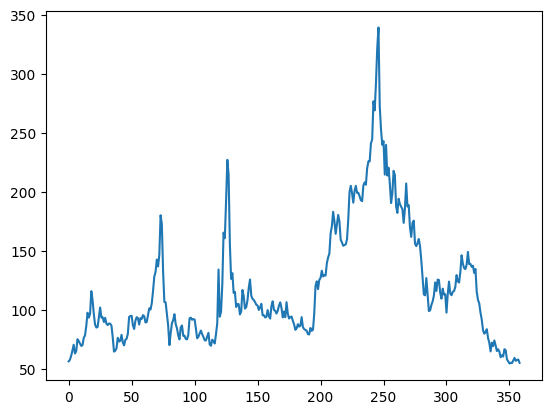

In [30]:
history_1_df = pd.DataFrame(history[1])
history_1_df.price.plot()

<Axes: >

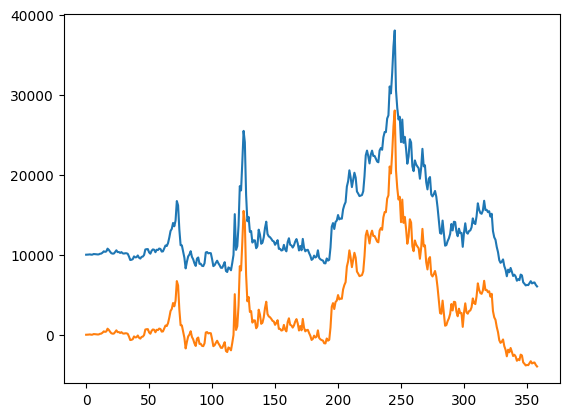

In [31]:
history_1_df.reward.plot()
(history_1_df.reward - 10000).plot()


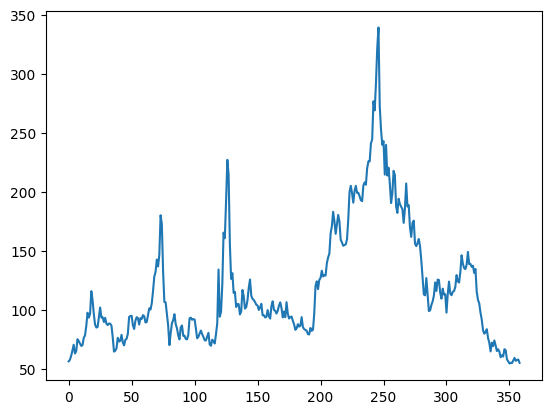

In [34]:
# series = history_1_df.reward - 10000
series_2 = history_1_df.price

# plt.plot(series)
plt.plot(history_1_df.price)
plt.plot(history_1_df.reward)